### Topics

- Requests and getting webpages
- Tidying HTML
- Web Scraping with BS
    - Traversal
- simple parallelization
- Storing Snapshots by using python dill
- Exploration
- Stock selection using simple filters

### Imports

In [156]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_seq_items', None)
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [157]:
np.set_printoptions(threshold=np.nan)

import warnings
import traceback

warnings.filterwarnings('ignore')
import argparse
import re
import sys, os

sys.path.append(os.getcwd())

import os
import requests
from requests.exceptions import ConnectionError

import bs4
from bs4 import BeautifulSoup
from fastnumbers import isfloat
from fastnumbers import fast_float
from multiprocessing.dummy import Pool as ThreadPool 
import more_itertools
from random import shuffle

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline
import json
from tidylib import tidy_document

import seaborn as sns
sns.set_style('whitegrid')





In [158]:
def is_dataframe(df):
    if df is not None and type(df)==pd.core.frame.DataFrame:
        return True
    return False

def ffloat(string):
    if string is None:
        return np.nan
    if type(string)==float or type(string)==int or type(string)==np.int64 or type(string)==np.float64:
        return string
    return fast_float(string.split(" ")[0].replace(',','').replace('%',''),default=np.nan)

def ffloat_list(string_list):
    return list(map(ffloat,string_list))

def remove_multiple_spaces(string):
    if type(string)==str:
        return ' '.join(string.split())
    return string

### Requests and Getting Content
- Status code
- Getting Text Content
- Getting JSON Content
- Error Handling

#### Getting a page and its status

In [159]:
page_response = requests.get("http://www.example.com/", timeout=240)
page_response.status_code
str(page_response.content).replace("\\n","")

200

'b\'<!doctype html><html><head>    <title>Example Domain</title>    <meta charset="utf-8" />    <meta http-equiv="Content-type" content="text/html; charset=utf-8" />    <meta name="viewport" content="width=device-width, initial-scale=1" />    <style type="text/css">    body {        background-color: #f0f0f2;        margin: 0;        padding: 0;        font-family: "Open Sans", "Helvetica Neue", Helvetica, Arial, sans-serif;            }    div {        width: 600px;        margin: 5em auto;        padding: 50px;        background-color: #fff;        border-radius: 1em;    }    a:link, a:visited {        color: #38488f;        text-decoration: none;    }    @media (max-width: 700px) {        body {            background-color: #fff;        }        div {            width: auto;            margin: 0 auto;            border-radius: 0;            padding: 1em;        }    }    </style>    </head><body><div>    <h1>Example Domain</h1>    <p>This domain is established to be used for illustr

#### Getting Json and parsing it

In [160]:
url = "https://jsonplaceholder.typicode.com/posts/1"
page_response = requests.get(url, timeout=240)
page_response.status_code
page_response.json()

content = page_response.json()
content.keys()

200

{'body': 'quia et suscipit\nsuscipit recusandae consequuntur expedita et cum\nreprehenderit molestiae ut ut quas totam\nnostrum rerum est autem sunt rem eveniet architecto',
 'id': 1,
 'title': 'sunt aut facere repellat provident occaecati excepturi optio reprehenderit',
 'userId': 1}

dict_keys(['userId', 'id', 'title', 'body'])

#### Checking Status Codes for errors

In [161]:
def request_with_check(url):
    page_response = requests.get(url, timeout=240)
    status = page_response.status_code
    if status>299:
        raise AssertionError("page content not found, status: %s"%status)
    return page_response

In [162]:
request_with_check("https://www.google.co.in/mycustom404page")

AssertionError: page content not found, status: 404

In [163]:
request_with_check("https://www.google.co.in/")

<Response [200]>

### Parsing and Traversal

- Getting body of a page and rendering it
- Inspecting Elements in Chrome
- Ways of getting element contents
- Traversals of childrens
- Getting Text and numbers
- Tables

#### Rendering HTML in Jupyter notebook

In [164]:
from IPython.core.display import HTML
HTML("<b>Rendered HTML</b>")


Here We download the page, parse using BeautifulSoup and then find the body tag content. Next we render the body tag.

In [165]:
page_response = requests.get("http://www.example.com/", timeout=240)
page_content = BeautifulSoup(page_response.content, "html.parser")
HTML(str(page_content.find("body")))

#### Finding elements by attributes

```python
page_content.find_all("p")
page_content.find("p",attrs={"class":"my-id"})
page_content.find_all("p",attrs={"id":"my-id"})
page_content.find_all("p",attrs={"id":"my-id"})
```

`.find` finds the first occurence.
You can check other find_* (find_next,find_previous etc)

Once you have the element you can do `.text` to get its textual content.

Like

```python
elem = page_content.find("p",attrs={"class":"my-id"})
text = elem.text
```

#### Getting Children of an element in Array

In [166]:
body = page_content.find("body")
body_div = body.find("div")
list(body_div.children)

['\n',
 <h1>Example Domain</h1>,
 '\n',
 <p>This domain is established to be used for illustrative examples in documents. You may use this
     domain in examples without prior coordination or asking for permission.</p>,
 '\n',
 <p><a href="http://www.iana.org/domains/example">More information...</a></p>,
 '\n']

As you see the first and last element is "\n" and not actual HTML elements so we will filter them. The next function does that.

In [167]:

def get_children(html_content):
    return [item for item in html_content.children if type(item)==bs4.element.Tag]

In [168]:
get_children(body_div)

[<h1>Example Domain</h1>,
 <p>This domain is established to be used for illustrative examples in documents. You may use this
     domain in examples without prior coordination or asking for permission.</p>,
 <p><a href="http://www.iana.org/domains/example">More information...</a></p>]

#### Parsing HTML tables and table like structures

In [169]:
html = '''
<table>
    <tr>
        <td>Month</td>
        <td>Price</td>
    </tr>
    <tr>
        <td>July</td>
        <td>2</td>
    </tr>
    <tr>
        <td>August</td>
        <td>4</td>
    </tr>
    <tr>
        <td>September</td>
        <td>3</td>
    </tr>
    <tr>
        <td>October</td>
        <td>2</td>
    </tr>
</table>

'''

html = BeautifulSoup(html,"html.parser")

In [170]:




def get_table_simple(portfolio_table,is_table_tag=True):
    portfolio_elems = portfolio_table.find_all('tr') if is_table_tag else get_children(portfolio_table)
    table_data = list()
    for row in portfolio_elems:
        
        row_data = list()
        row_elems = get_children(row)
        for elem in row_elems:
            text = elem.text.strip().replace("\n","")
            text = remove_multiple_spaces(text)
            if len(text)==0:
                continue
            row_data.append(text)
        table_data.append(row_data)
    return table_data


        

In [171]:
get_table_simple(html)

[['Month', 'Price'],
 ['July', '2'],
 ['August', '4'],
 ['September', '3'],
 ['October', '2']]

In [172]:
html = '''
<html>
<body>
<div id="table" class="FL" style="width:210px; padding-right:10px">
    <div class="PA7 brdb">
        <div class="FL gL_10 UC">MARKET CAP (Rs Cr)</div>
        <div class="FR gD_12">63,783.84</div>
        <div class="CL"></div>
    </div>
    <div class="PA7 brdb">
        <div class="FL gL_10 UC">P/E</div>
        <div class="FR gD_12">17.27</div>
        <div class="CL"></div>
    </div>
    <div class="PA7 brdb">
        <div class="FL gL_10 UC">BOOK VALUE (Rs)</div>
        <div class="FR gD_12">589.29</div>
        <div class="CL"></div>
    </div>
    <div class="PA7 brdb">
        <div class="FL gL_10 UC">DIV (%)</div>
        <div class="FR gD_12">4750.00%</div>
        <div class="CL"></div>
    </div>
    <div class="PA7 brdb">
        <div class="FL gL_10 UC">Market Lot</div>
        <div class="FR gD_12">1</div>
        <div class="CL"></div>
    </div>
    <div class="PA7 brdb">
        <div class="FL gL_10 UC">INDUSTRY P/E</div>
        <div class="FR gD_12">19.99</div>
        <div class="CL"></div>
    </div>
</div>
</body>
</html>
'''

In [173]:
html, errors = tidy_fragment(html)
content = BeautifulSoup(html,"html.parser")
get_table_simple(content.find("div",attrs={"id":"table"}),is_table_tag=False)

[['MARKET CAP (Rs Cr)', '63,783.84'],
 ['P/E', '17.27'],
 ['BOOK VALUE (Rs)', '589.29'],
 ['DIV (%)', '4750.00%'],
 ['Market Lot', '1'],
 ['INDUSTRY P/E', '19.99']]

### HTML Tidying

#### Without Tidying

We remove a closing </tr> from previous html and see if BeautifulSoup can parse it correctly. Look for closing tr of July

In [174]:
html = '''
<table>
    <tr>
        <td>Month</td>
        <td>Price</td>
    </tr>
    <tr>
        <td>July</td>
        <td>2</td>
    
    <tr>
        <td>August</td>
        <td>4</td>
    </tr>
    <tr>
        <td>September</td>
        <td>3</td>
    </tr>
    <tr>
        <td>October</td>
        <td>2</td>
    </tr>
</table>

'''

content = BeautifulSoup(html,"html.parser")
get_table_simple(content)

[['Month', 'Price'],
 ['July', '2', 'August4', 'September3', 'October2'],
 ['August', '4'],
 ['September', '3'],
 ['October', '2']]

#### With Tidying

In [175]:
from tidylib import tidy_document
from tidylib import tidy_fragment
html, errors = tidy_fragment(html)
html.replace("\n","")
content = BeautifulSoup(html,"html.parser")
get_table_simple(content)

'<table>  <tr>    <td>      Month    </td>    <td>      Price    </td>  </tr>  <tr>    <td>      July    </td>    <td>      2    </td>  </tr>  <tr>    <td>      August    </td>    <td>      4    </td>  </tr>  <tr>    <td>      September    </td>    <td>      3    </td>  </tr>  <tr>    <td>      October    </td>    <td>      2    </td>  </tr></table>'

[['Month', 'Price'],
 ['July', '2'],
 ['August', '4'],
 ['September', '3'],
 ['October', '2']]

As you can see the tidying added a </tr> at the right place and we got our content parsed properly.

### Lib for fetching details

In [176]:

def get_ratios(url):
    page_response = requests.get(url, timeout=240)
    page_content, errors = tidy_document(page_response.content,options={'numeric-entities':1})
    page_content = BeautifulSoup(page_content, "html.parser")
    table_content = page_content.find_all('table',attrs={'class':'table4'})[-1]
    if "Data Not Available" in table_content.text:
         return {}
    
    table = get_table_simple(table_content)
    dates = table[2]
    rows = table[3:]
    ratios = {}
    ratios['dates'] = dates
    
    for row in rows:
        if len(row)>1:
            ratios[row[0]] = ffloat_list(row[1:])
    
    needed_keys = [('dates','ratios_dates'),
                   ('Diluted EPS (Rs.)','ratios_diluted_eps'),
                   ('Revenue from Operations/Share (Rs.)','ratios_revenue_per_share'),
                   ('PBT/Share (Rs.)','ratios_pbt_per_share'),
                   ('PBT Margin (%)','ratios_pbt_margin_per_share'),
                   ('Total Debt/Equity (X)','ratios_de'),
                   ('Asset Turnover Ratio (%)','ratios_asset_turnover_ratio'),
                   ('Current Ratio (X)','ratios_cr'),
                   ('EV/EBITDA (X)','ratios_ev_by_ebitda'),
                   ('Price/BV (X)','ratios_pb')]
    
    ratios = { your_key[1]: ratios[your_key[0]] if your_key[0] in ratios else [] for your_key in needed_keys }
    return ratios

In [177]:

def get_past_prices(sc_id):
    bse_url = "https://www.moneycontrol.com/tech_charts/bse/his/%s.csv"%sc_id
    nse_url = "https://www.moneycontrol.com/tech_charts/nse/his/%s.csv"%sc_id
    
    past_prices_nse = pd.read_csv(nse_url,header=None,names=['open','high','low','close','volume',1,2,3,4])[['open','high','low','close','volume']]
    past_prices_nse.index = pd.to_datetime(past_prices_nse.index)
    
    past_prices_bse = pd.read_csv(bse_url,header=None,names=['open','high','low','close','volume',1,2,3,4])[['open','high','low','close','volume']]
    past_prices_bse.index = pd.to_datetime(past_prices_bse.index)
    
    
    if len(past_prices_nse)>=len(past_prices_bse):
        past_prices = past_prices_nse
    else:
        past_prices = past_prices_bse
    return past_prices

In [178]:

def get_scrip_info(url,name):
    original_url = url
    key_val_pairs = {}
    key_val_pairs["original_url"] = original_url
    if not url.startswith("http"):
        url = "https://www.moneycontrol.com"+url
    try:
        page_response = requests.get(url, timeout=240)
        page_content = BeautifulSoup(page_response.content, "html.parser")
        scrip_name = name
        price = ffloat(page_content.find('div',attrs={'id':'Nse_Prc_tick_div'}).text.split(" ")[0].replace(',',''))
        name = page_content.find('h1',attrs={'class':'company_name'}).text
        
        yearly_high = page_content.find('span',attrs={'id':'n_52high'}).text.strip()
        yearly_low = page_content.find('span',attrs={'id':'n_52low'}).text.strip()
        html_data_content = page_content.find('div', attrs={'id': 'mktdet_1'})
        
        petable = get_table_simple(get_children(html_data_content)[0],is_table_tag=False)
        pbtable = get_table_simple(get_children(html_data_content)[1],is_table_tag=False)
        
        side_nav = page_content.find('dl',attrs={'id':'slider'})
        ratio_url = side_nav.find_all('dd')[2].find_all('a')[7]['href']
        ratio_url = "https://www.moneycontrol.com"+ratio_url
        ratios = get_ratios(ratio_url)
        
        
        volume = ffloat(page_content.find('span',attrs={'id':'nse_volume'}).text)
        
        sc_id = page_content.find('input',attrs={'id':'sc_id'}).get('value').lower()
        
        key_val_pairs = {**key_val_pairs, **ratios}
        
        past_prices = get_past_prices(sc_id)
        
        data_table = list()
        data_table.extend(petable)
        data_table.extend(pbtable)
        

        for row in data_table:
            k = row[0]
            if len(row)<2:
                v=None
            else:
                v = row[1].split(" ")[0].replace(',','')
            key_val_pairs[k]=v

        

        key_val_pairs["pe"] = ffloat(key_val_pairs.pop('P/E'))
        key_val_pairs["book_value"] = ffloat(key_val_pairs.pop('BOOK VALUE (Rs)'))
        key_val_pairs["deliverables"] = ffloat(key_val_pairs.pop('DELIVERABLES (%)'))
        key_val_pairs["eps"] = ffloat(key_val_pairs.pop('EPS (TTM)'))
        key_val_pairs["industry_pe"] = ffloat(key_val_pairs.pop('INDUSTRY P/E'))
        if 'MARKET CAP (Rs Cr)' in key_val_pairs:
            key_val_pairs["market_cap"] = key_val_pairs.pop('MARKET CAP (Rs Cr)')
        elif '**MARKET CAP (Rs Cr)' in key_val_pairs:
            key_val_pairs["market_cap"] = key_val_pairs.pop('**MARKET CAP (Rs Cr)')
        key_val_pairs["market_cap"] = ffloat(key_val_pairs["market_cap"])
        key_val_pairs["pb"] = ffloat(key_val_pairs.pop('PRICE/BOOK'))
        key_val_pairs["pc"] = ffloat(key_val_pairs.pop('P/C'))
        key_val_pairs['price'] = ffloat(price)
        key_val_pairs['volume'] = volume
        key_val_pairs["name"] = name
        key_val_pairs["scrip_name"] = scrip_name
        key_val_pairs["yearly_low"] = ffloat(yearly_low)
        key_val_pairs["yearly_high"] = ffloat(yearly_high)

        key_val_pairs['past_prices'] = past_prices
        key_val_pairs['de'] = np.nan
        key_val_pairs['ev_by_ebitda'] = np.nan
        if "ratios_ev_by_ebitda" in key_val_pairs and len(key_val_pairs["ratios_ev_by_ebitda"])>0:
            key_val_pairs['ev_by_ebitda'] = key_val_pairs["ratios_ev_by_ebitda"][0]
        
        if "ratios_de" in key_val_pairs and len(key_val_pairs["ratios_de"])>0:
            key_val_pairs['de'] = key_val_pairs["ratios_de"][0]
        key_val_pairs['failure'] = False

        del key_val_pairs['DIV (%)']
        del key_val_pairs['DIV YIELD.(%)']
        del key_val_pairs['FACE VALUE (Rs)']
        del key_val_pairs['Market Lot']
    except Exception as e:
        traceback.print_exc()
        key_val_pairs['failure'] = True
        key_val_pairs['err'] = "Error for: %s"%original_url
        print(key_val_pairs['err'])
        return key_val_pairs
        
    return key_val_pairs


In [179]:
def get_scrip_info_by_nse_name(nse_name):
    url = "https://www.moneycontrol.com/mccode/common/autosuggesion.php?classic=true&query=%s&type=1&format=json"%nse_name
    page_response = requests.get(url, timeout=240)
    json_text = page_response.text
    data = json.loads(json_text)
    if len(data)>1:
        key_val_pairs = {}
        key_val_pairs['failure'] = True
        key_val_pairs['err'] = "Search unsuccessful for %s"%nse_name
    scrip_url = data[0]['link_src']
    return get_scrip_info(scrip_url,nse_name)

### Company Analysis and Filtering 



#### Generic Filter one variable upper lower limits

In [180]:
def get_generic_filter(param_name,lower_limit=None,upper_limit=None,
                                     replacement_nan=None,replacement_not_present=None):
    def filter_fn(stock_detail):
        param = replacement_not_present
        if param_name in stock_detail:
            param = ffloat(stock_detail[param_name])
            
        if np.isnan(param):
            param = replacement_nan
        
        if param is None or np.isnan(param):
            return False
        
        if param<=upper_limit and param>=lower_limit:
            return True
        return False
        
    return filter_fn

In [181]:
def get_all_company_details(nse_names,
                            threadpool_size=8):
    # filters is a list of functions returning T/F, They are always
    batch_size = 5*threadpool_size
    pool = ThreadPool(threadpool_size)
    scrip_details = pool.map(get_scrip_info_by_nse_name, nse_names)
    failures = list(filter(lambda x:x['failure'],scrip_details))
    successes = list(filter(lambda x:not x['failure'],scrip_details))
    successes={scrip['scrip_name']:scrip for scrip in successes}
    return successes,failures


In [182]:
some_nse_companies = ["AARTIDRUGS","ATUL","AUROPHARMA","AXISBANK","BAJAJ-AUTO","BANKBARODA",
                     "BHEL","DABUR","DBCORP","DIVISLAB","EVEREADY","EICHERMOT",
                     "GLENMARK","GREAVESCOT","HDFC","HDFCBANK","INDIABULLS","ITC","KOTAKBANK","KEC"]
successes,failures = get_all_company_details(some_nse_companies,
                        threadpool_size=4);

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Traceback (most recent call last):
  File "<ipython-input-178-c55d053cea0b>", line 12, in get_scrip_info
    price = ffloat(page_content.find('div',attrs={'id':'Nse_Prc_tick_div'}).text.split(" ")[0].replace(',',''))
AttributeError: 'NoneType' object has no attribute 'text'


Error for: http://www.moneycontrol.com/india/stockpricequote/financehousing/hdfcwarrants/HDF03


Traceback (most recent call last):
  File "<ipython-input-178-c55d053cea0b>", line 12, in get_scrip_info
    price = ffloat(page_content.find('div',attrs={'id':'Nse_Prc_tick_div'}).text.split(" ")[0].replace(',',''))
AttributeError: 'NoneType' object has no attribute 'text'


Error for: http://www.moneycontrol.com/india/stockpricequote/financegeneral/indiabullsfinancialservices/IFS03


Traceback (most recent call last):
  File "<ipython-input-178-c55d053cea0b>", line 12, in get_scrip_info
    price = ffloat(page_content.find('div',attrs={'id':'Nse_Prc_tick_div'}).text.split(" ")[0].replace(',',''))
AttributeError: 'NoneType' object has no attribute 'text'


Error for: http://www.moneycontrol.com/india/stockpricequote/paper/itcbhadrachalam/ITC04


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [183]:
len(successes.keys())
len(failures)

17

3

#### Write to File

In [184]:

import dill
with open('tutorial_results.pkl', 'wb') as f:
    dill.dump(successes, f)
    dill.dump(failures, f)

#### Read from File 

In [185]:
import dill
with open('tutorial_results.pkl', 'rb') as f:
    accumulator = dill.load(f)
    failures = dill.load(f)

### Portfolio Selection based on Data

In [186]:
def filter_companies(all_scrips,filters=[]):
    scrip_details = list(all_scrips.values())
    
    for i in range(len(filters)):
        scrip_details = list(filter(filters[i],scrip_details))
    
    return scrip_details
    
    

In [187]:
def get_df_from_scrip_details(scrip_details):
    other_cols = ['name','scrip_name']
    numeric_cols = ['book_value', 'price','deliverables', 'eps', 'industry_pe', 
                    'market_cap', 'pb', 'pc', 'pe','de',
                   'yearly_high','yearly_low']
    
    
    all_cols = other_cols+numeric_cols
    scrip_details = [{ your_key: scrip[your_key] for your_key in all_cols } for scrip in scrip_details]
    scrip_details = pd.DataFrame.from_records(scrip_details)
    scrip_details[numeric_cols] = scrip_details[numeric_cols].applymap(ffloat)
    scrip_details = scrip_details[all_cols]
    return scrip_details

In [188]:
pe_filter = get_generic_filter("pe",lower_limit=0,upper_limit=20,
                                     replacement_nan=-1,replacement_not_present=-1)
pb_filter = get_generic_filter("pb",lower_limit=0,upper_limit=4,
                                     replacement_nan=-1,replacement_not_present=-1)
filtered_companies = filter_companies(accumulator,filters=[pe_filter,pb_filter])
get_df_from_scrip_details(filtered_companies)

,name,scrip_name,book_value,price,deliverables,eps,industry_pe,market_cap,pb,pc,pe,de,yearly_high,yearly_low
0,Aarti Drugs Ltd.,AARTIDRUGS,183.69,552.70,65.40,31.13,29.23,1300.20,3.00,11.69,17.71,1.11,785.00,485.00
1,Aurobindo Pharma Ltd.,AUROPHARMA,174.92,591.05,23.77,30.94,29.23,34638.86,3.38,15.98,19.11,0.34,809.45,527.00
2,DB Corp Ltd.,DBCORP,104.50,249.75,61.27,16.94,13.95,4618.16,2.40,11.43,14.81,0.04,388.00,235.00
3,Glenmark Pharma Ltd.,GLENMARK,370.38,572.75,24.32,35.95,29.23,16180.93,1.55,14.29,15.95,0.29,746.00,493.50
4,Greaves Cotton Ltd.,GREAVESCOT,39.33,143.75,78.25,8.30,24.56,3511.69,3.66,13.77,17.33,NaN,164.95,112.35


In [189]:
de_filter = get_generic_filter("de",lower_limit=0,upper_limit=1,
                                     replacement_nan=0,replacement_not_present=0)
filtered_companies = filter_companies(accumulator,filters=[pe_filter,pb_filter,de_filter])
get_df_from_scrip_details(filtered_companies)

,name,scrip_name,book_value,price,deliverables,eps,industry_pe,market_cap,pb,pc,pe,de,yearly_high,yearly_low
0,Aurobindo Pharma Ltd.,AUROPHARMA,174.92,591.05,23.77,30.94,29.23,34638.86,3.38,15.98,19.11,0.34,809.45,527.00
1,DB Corp Ltd.,DBCORP,104.50,249.75,61.27,16.94,13.95,4618.16,2.40,11.43,14.81,0.04,388.00,235.00
2,Glenmark Pharma Ltd.,GLENMARK,370.38,572.75,24.32,35.95,29.23,16180.93,1.55,14.29,15.95,0.29,746.00,493.50
3,Greaves Cotton Ltd.,GREAVESCOT,39.33,143.75,78.25,8.30,24.56,3511.69,3.66,13.77,17.33,NaN,164.95,112.35


In [190]:
def score_company_on_filters(all_scrips,filters={}):
    all_scrips = list(all_scrips.values())
    other_cols = ['name','scrip_name']
    numeric_cols = ['price', 
                    'market_cap', 'pb', 'pe','de',
                   'yearly_high','yearly_low']
    all_cols = other_cols+list(filters.keys())+numeric_cols
    scrip_details = []
    for scrip in all_scrips:
        for key in filters.keys():
            scrip[key] = filters[key](scrip)
        scrip_detail = { your_key: scrip[your_key] for your_key in all_cols }
        
        scrip_details.append(scrip_detail)
        
    scrip_details = pd.DataFrame.from_records(scrip_details)
    scrip_details[numeric_cols] = scrip_details[numeric_cols].applymap(ffloat)
    scrip_details = scrip_details[all_cols]
    return scrip_details
    

In [191]:
scores_df = score_company_on_filters(accumulator,filters={"pe_filter":pe_filter,"pb_filter":pb_filter,"de_filter":de_filter})

In [192]:
scores_df

,name,scrip_name,pe_filter,pb_filter,de_filter,price,market_cap,pb,pe,de,yearly_high,yearly_low
0,Aarti Drugs Ltd.,AARTIDRUGS,True,True,False,552.70,1300.20,3.00,17.71,1.11,785.00,485.00
1,Atul Ltd.,ATUL,False,True,True,2740.70,8103.44,3.69,25.31,0.00,3094.70,1950.00
2,Aurobindo Pharma Ltd.,AUROPHARMA,True,True,True,591.05,34638.86,3.38,19.11,0.34,809.45,527.00
3,Axis Bank Ltd.,AXISBANK,False,True,True,553.25,142176.80,2.24,517.43,NaN,627.60,447.50
4,Bajaj Auto Ltd.,BAJAJ-AUTO,True,False,True,2686.75,77493.93,4.06,18.19,0.00,3468.35,2605.00
5,Bank Of Baroda,BANKBARODA,False,True,True,137.85,36521.35,0.84,NaN,NaN,206.65,109.50
6,Bharat Heavy Electricals Ltd.,BHEL,False,True,True,71.15,26122.01,0.81,29.65,0.00,107.95,64.45
7,Dabur India Ltd.,DABUR,False,False,True,386.00,68071.83,16.11,63.49,0.07,396.40,296.50
8,DB Corp Ltd.,DBCORP,True,True,True,249.75,4618.16,2.40,14.81,0.04,388.00,235.00
9,Divis Laboratories Ltd.,DIVISLAB,False,False,True,1103.00,29229.42,4.66,33.61,0.01,1223.00,611.00


### Plotting and Analysis

#### PE vs MarketCap Corr

(1, 50)

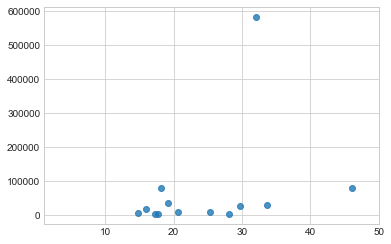

In [193]:
pe_list = []
mcap_list = []
for key in accumulator.keys():
    prices_df = accumulator[key]['past_prices']
    
    pe = accumulator[key]['pe']
    mcap = accumulator[key]['market_cap']
    
    pe_list.append(pe)
    mcap_list.append(mcap)
    
ax = sns.regplot(x=np.array(pe_list), y=np.array(mcap_list),fit_reg=False)
ax.set_xlim([1,50])
# ax.set_ylim([10000,800000])
plt.show()

#### Price Volume Charts

In [194]:
def generate_price_chart(stock_df,name,days=1095,ewmas=[],other_technical_indicators=[]):
    plt.figure(figsize=(16,8))
    ts_df = stock_df.tail(days)
    handles = []
    p1, = plt.plot(ts_df.index, ts_df['close'],label="price")
    handles.append(p1)
    for ewma in ewmas:
        y = ts_df['close'].ewm(span=ewma).mean()
        p2, = plt.plot(ts_df.index, y,label="%s day ewma"%ewma)
        handles.append(p2)
    plt.legend(handles=handles)
    plt.title(name)
    plt.ylabel('Closing Price')
    plt.show()

In [195]:

def generate_price_volume_chart(stock_df,name,days=1095,ewmas=[],other_technical_indicators=[]):
    plt.figure(figsize=(16,8))
    top = plt.subplot2grid((6,6), (0, 0), rowspan=4, colspan=6)
    bottom = plt.subplot2grid((6,6), (4,0), rowspan=2, colspan=6)
    ts_df = stock_df.tail(days)
    handles = []
    p1, = top.plot(ts_df.index, ts_df['close'],label="price")
    handles.append(p1)
    for ewma in ewmas:
        y = ts_df['close'].ewm(span=ewma).mean()
        p2, = top.plot(ts_df.index, y,label="%s day ewma"%ewma)
        handles.append(p2)
    top.legend(handles=handles)
    bottom.bar(ts_df.index, ts_df['volume']) 
    bottom.set_ylim([ts_df['volume'].min(),ts_df['volume'].max()])
#     sns.lineplot(x="index", y="close", data=ts_df.reset_index(),ax=top)
#     sns.barplot(x="index", y="volume", data=ts_df.reset_index(),ax=bottom)

    # set the labels
    top.axes.get_xaxis().set_visible(False)
    top.set_title(name)
    top.set_ylabel('Closing Price')
    bottom.set_ylabel('Volume')
    
    plt.show()

In [196]:
hero = get_scrip_info_by_nse_name('HEROMOTOCO')
exide = get_scrip_info_by_nse_name('EXIDEIND')

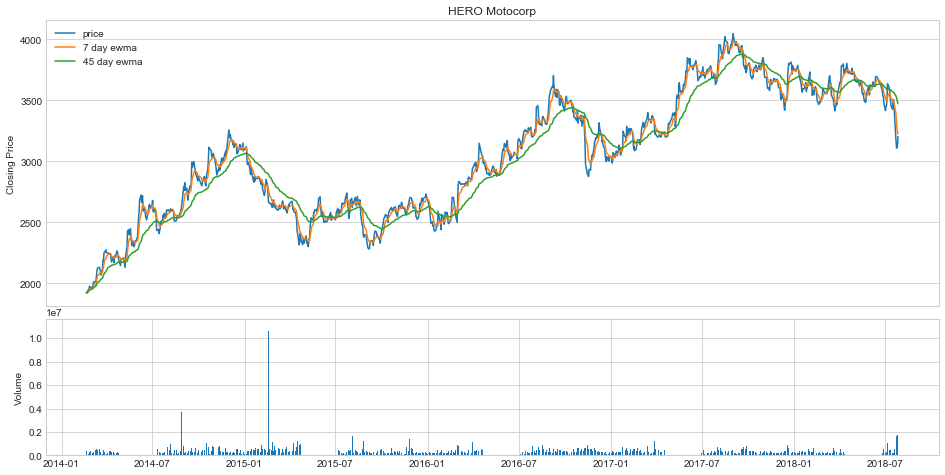

In [30]:
generate_price_volume_chart(hero['past_prices'],"HERO Motocorp",days=1095,ewmas=[7,45])

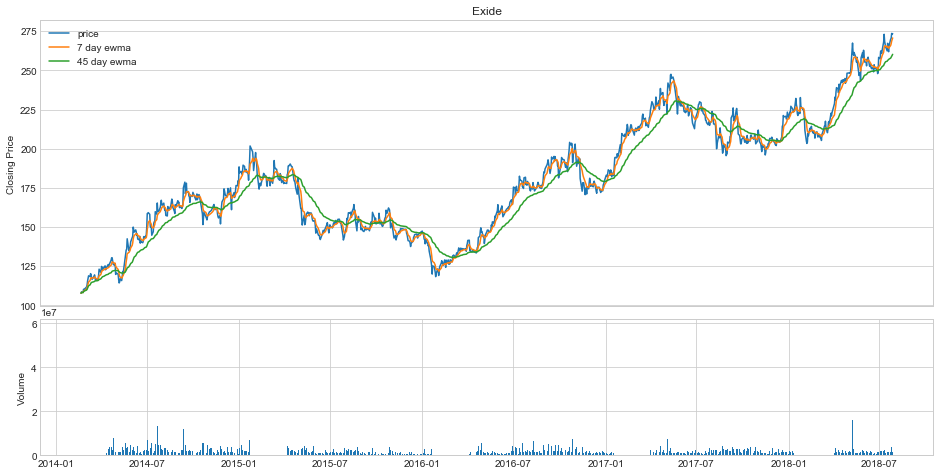

In [31]:
generate_price_volume_chart(exide['past_prices'],"Exide",days=1095,ewmas=[7,45])


#### Returns analysis

In [32]:

def generate_returns_chart(stocks,days=1095):
    plt.figure(figsize=(16,8))
    stocks = {key:stocks[key].tail(days).apply(lambda x: x / x[0]) for key in stocks.keys()}
    handles = []
    for key in stocks.keys():
        y = stocks[key]['close']
        p2, = plt.plot(stocks[key].index, y,label=key)
        handles.append(p2)
    plt.legend(handles=handles)
    plt.title("Comparative returns")
    plt.ylabel('Comparative Returns')
    
    plt.show()

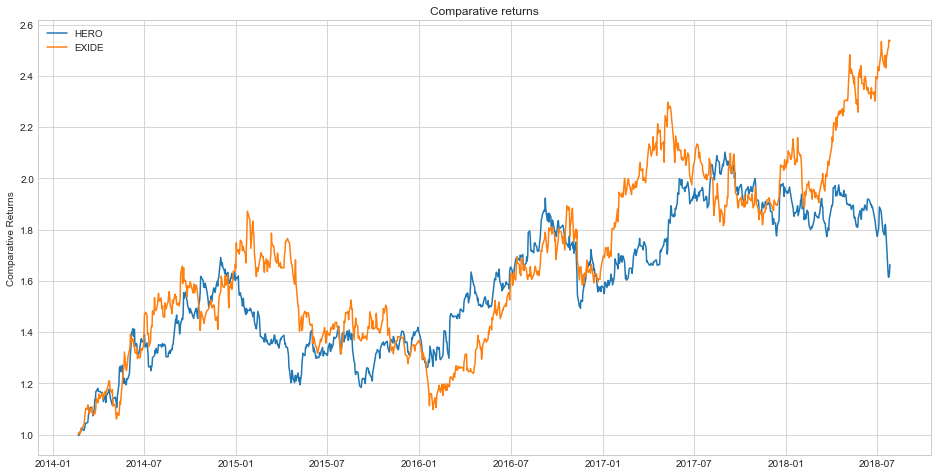

In [33]:
generate_returns_chart({"HERO":hero['past_prices'],
                       "EXIDE":exide['past_prices']})

#### Volatility analysis

In [34]:
def generate_percent_change_chart(stocks,days=1095):
    plt.figure(figsize=(16,8))
    stocks = {key:stocks[key].tail(days).pct_change()*100 for key in stocks.keys()}
    handles = []
    for key in stocks.keys():
        stocks[key]['name'] = key
        y = stocks[key]['close']
        p2, = plt.plot(stocks[key].index, y,label=key)
        handles.append(p2)
    all_stocks = pd.concat(list(stocks.values()))
    plt.legend(handles=handles)
    plt.title("Daily Percent Changes Chart")
    plt.ylabel('Daily Percent Changes')
    plt.show()
    fig, ax = plt.subplots(figsize=(16,8))
    sns.boxplot(x="name", y="close", data=all_stocks,ax=ax);
    ax.xaxis.set_tick_params(rotation=90)
    plt.show()

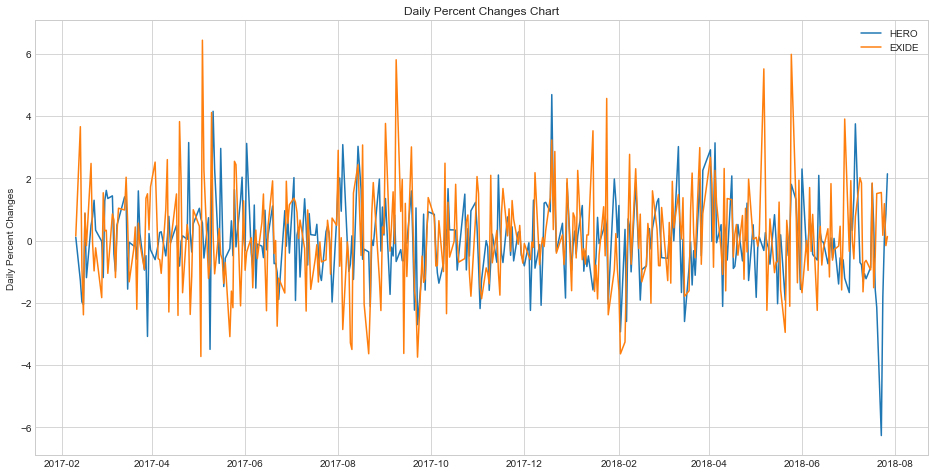

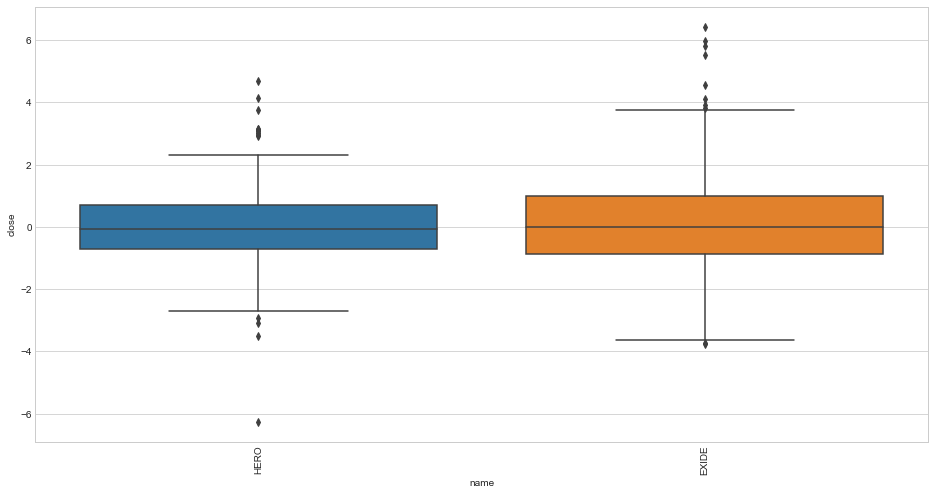

In [35]:

generate_percent_change_chart({"HERO":hero['past_prices'],
                       "EXIDE":exide['past_prices']},days=365)

#### Returns and Volatility of all companies we used

In [36]:
all_scrip_prices_df = {scrip["scrip_name"]:scrip['past_prices'] for scrip in accumulator.values()}


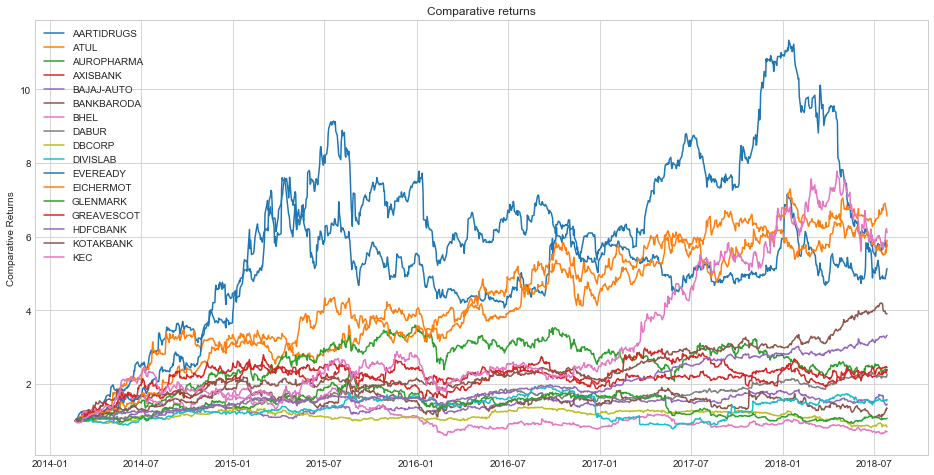

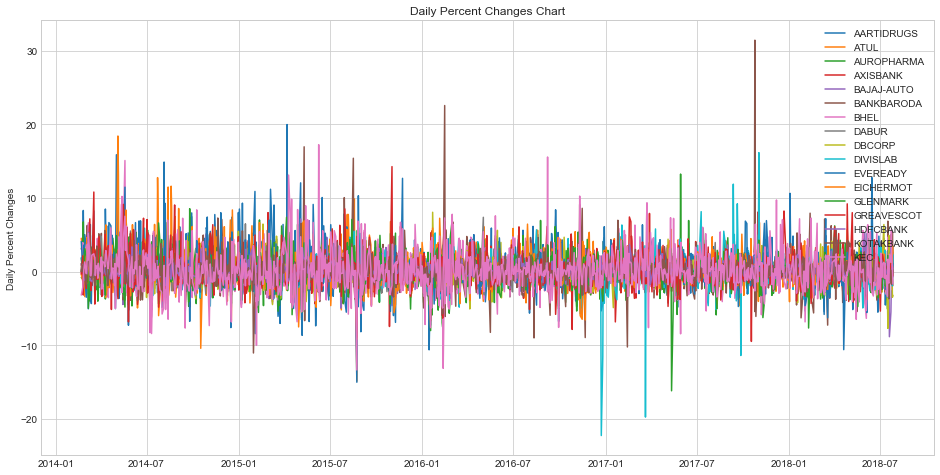

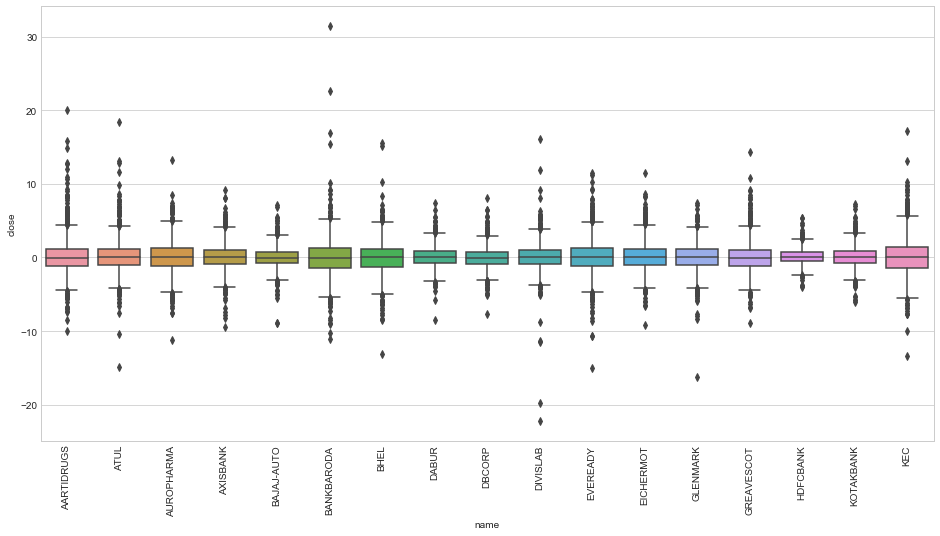

In [37]:
generate_returns_chart(all_scrip_prices_df)
generate_percent_change_chart({scrip["scrip_name"]:scrip['past_prices'] for scrip in accumulator.values()})

#### Nifty 50, Nifty 100, Nifty midcap 50 Analysis

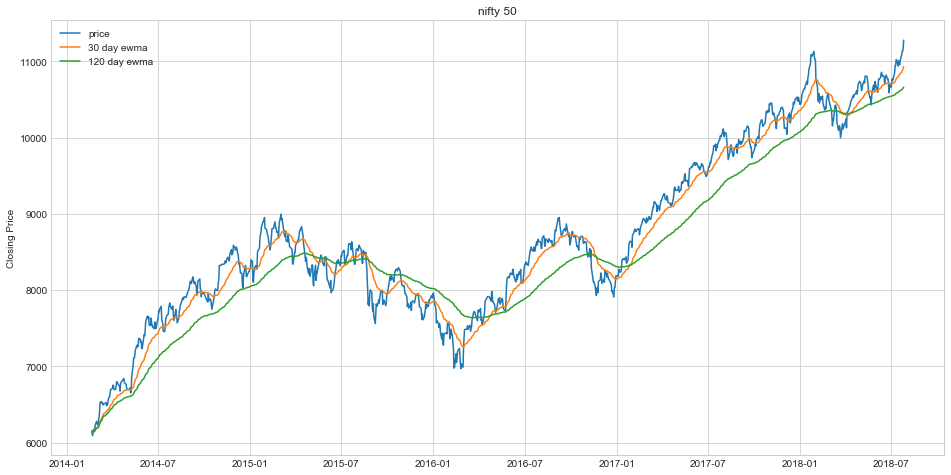

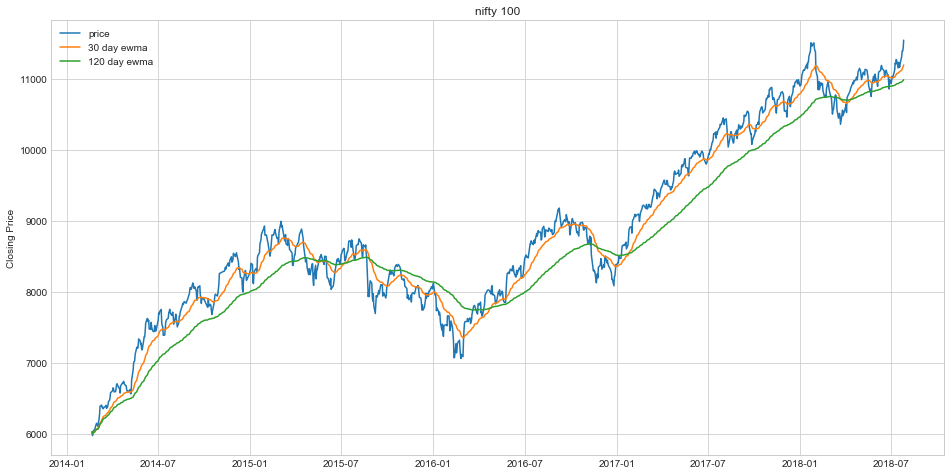

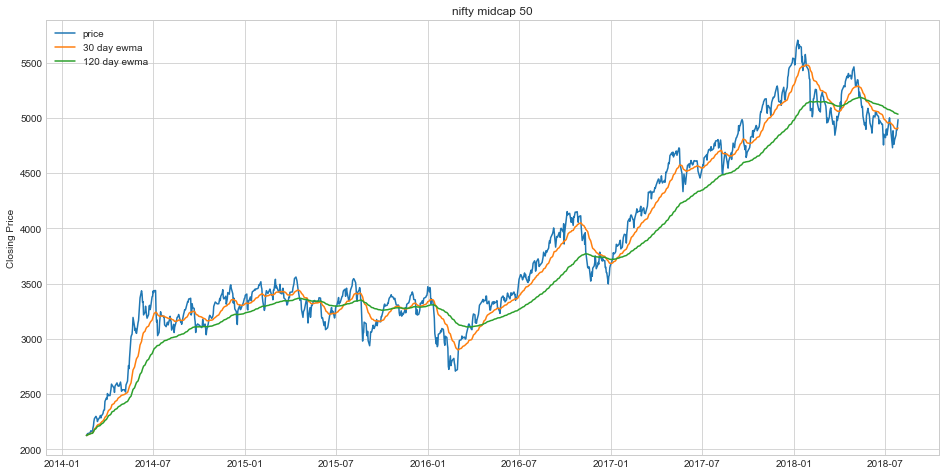

In [5]:
n50_url = "http://www.moneycontrol.com/tech_charts/nse/his/nifty.csv"
n50 = pd.read_csv(n50_url,header=None,names=['open','high','low','close','volume'])[['open','high','low','close','volume']]
n50.index = pd.to_datetime(n50.index)


n100_url = "http://www.moneycontrol.com/tech_charts/nse/his/cnx_100.csv"
n100 = pd.read_csv(n100_url,header=None,names=['open','high','low','close','volume'])[['open','high','low','close','volume']]
n100.index = pd.to_datetime(n100.index)

nmid_url = "http://www.moneycontrol.com/tech_charts/nse/his/nifty_midcap_50.csv"
nmid = pd.read_csv(nmid_url,header=None,names=['open','high','low','close','volume'])[['open','high','low','close','volume']]
nmid.index = pd.to_datetime(nmid.index)



generate_price_chart(n50,"nifty 50",days=1095,ewmas=[30,120])
generate_price_chart(n100,"nifty 100",days=1095,ewmas=[30,120])
generate_price_chart(nmid,"nifty midcap 50",days=1095,ewmas=[30,120])


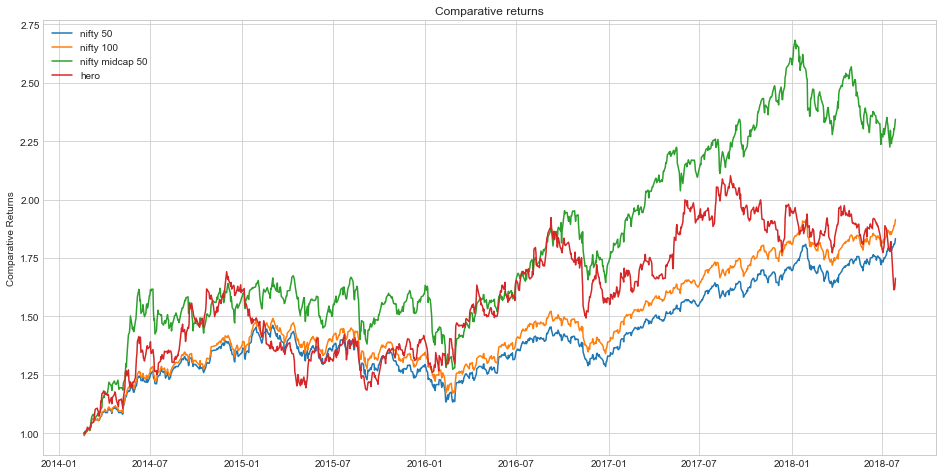

In [80]:
generate_returns_chart({"nifty 50":n50,"nifty 100":n100,"nifty midcap 50":nmid,"hero":hero['past_prices']['all_past_prices']})

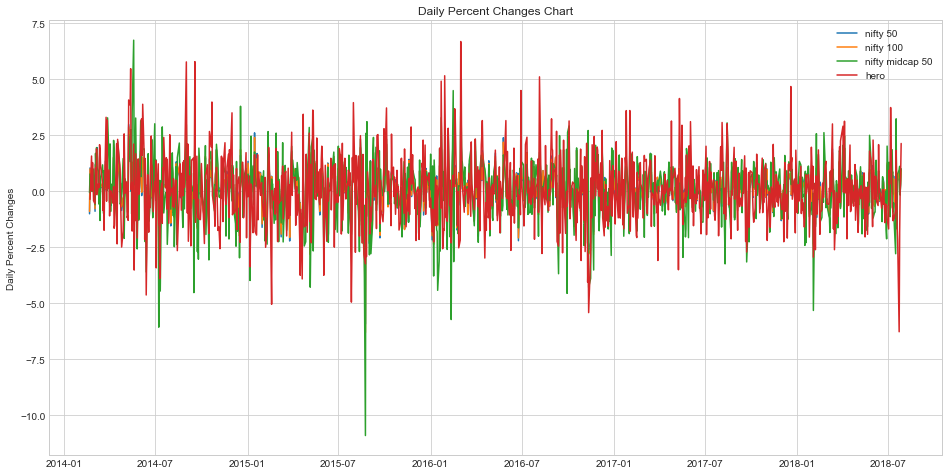

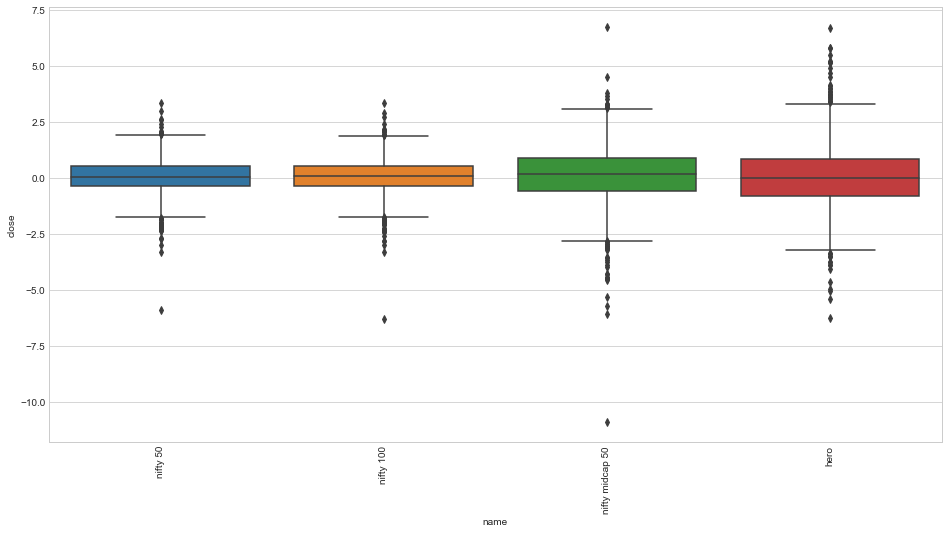

In [79]:



generate_percent_change_chart({"nifty 50":n50,"nifty 100":n100,"nifty midcap 50":nmid,"hero":hero['past_prices']['all_past_prices']},days=1095)


### References

- https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/
- https://mapattack.wordpress.com/2017/02/14/python-for-stocks-2/

more involved articles:

 - https://ntguardian.wordpress.com/2018/07/17/stock-data-analysis-python-v2/
 - https://nextjournal.com/hisham/stock-market
 